In [44]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [45]:
import gensim.downloader as api
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# Task 1:

wv = api.load('word2vec-google-news-300')
df_synonym = pd.read_csv('synonym.csv')
df_synonym.columns
df_synonym.head(5)

,question,answer,0,1,2,3
0,enormously,tremendously,appropriately,uniquely,tremendously,decidedly
1,provisions,stipulations,stipulations,interrelations,jurisdictions,interpretations
2,haphazardly,randomly,dangerously,densely,randomly,linearly
3,prominent,conspicuous,battered,ancient,mysterious,conspicuous
4,zenith,pinnacle,completion,pinnacle,outset,decline


In [47]:
# General Methods for Task 1

def compute_max(model, target, word1, word2, word3, word4, answer):
    # Determines the cosine similarity between two embeddings and retrieves the closest one to the target (question-word)
    words = [word1, word2, word3,word4]
    max_similarity = -1  
    selected_word = None

    for word in words:
        try:
            similarity = model.similarity(word, target)
            if similarity > max_similarity:
                # Keep the word with the greatest similarity to the target word
                max_similarity = similarity
                selected_word = word
        except KeyError:
            print(f"KeyError: {word}")
            continue
    if selected_word is None or target not in model.index_to_key or all(word not in model.index_to_key for word in words):
        label = 'guess'
    elif selected_word == answer:
        label = 'correct'
    else:
        label = 'wrong'

    return selected_word, label



def write_model_to_csv(name,model):
    # Writes a dataframe to a file demonstrating the best predicted synonym based on a question-word.
    # It also indicates whether the model correctly labeled the expected predicted word.

    df_synonym = pd.read_csv('synonym.csv')

    result_df = {
        'question' : [],
        'answer' : [],
        'predictions': [],
        'label': []
    }

    result_df['question'] = df_synonym['question']
    result_df['answer'] = df_synonym['answer']

    predictions = []
    labels = []
    
    for index in range(len(df_synonym)):
        prediction, label = compute_max(model, str(df_synonym['question'][index]), str(df_synonym['0'][index]),str(df_synonym['1'][index]), str(df_synonym['2'][index]),str(df_synonym['3'][index]),str(df_synonym['answer'][index]))
        predictions.append(prediction)
        
        labels.append(label)
    
    result_df['predictions'] = predictions
    result_df['label'] = labels
    pd.DataFrame(result_df).to_csv(f'{name}-details.csv', index=False)


def get_analysis(name, model):
    # Evaluates the model's performance 
    df_for_analysis = pd.read_csv(f'{name}-details.csv')

    label_counts = df_for_analysis['label'].value_counts()
    correct = label_counts.get('correct', 0)
    wrong = label_counts.get('wrong',0)
    guess = label_counts.get('guess', 0)
    v = correct + wrong
    line = f'{name}, {len(model.index_to_key)}, {correct}, {v}, {correct/v}'
    return line

def write_analysis(line):
    # Writes the model's performance to a csv file
    
    with open('analysis.csv', 'a+') as my_file:
        my_file.write(line + '\n')
  

    
    



In [62]:
# Task 1:

def analysis_part_one():
    write_model_to_csv('word2vec-google-news-300',wv)
    line = get_analysis('word2vec-google-news-300',wv)
    write_analysis(line)
analysis_part_one()

KeyError: peacefulness
KeyError: harshness
KeyError: weariness
KeyError: happiness


In [49]:
# Task 2: 

# Files of same size but different corpus
crawl_subwords = api.load('fasttext-wiki-news-subwords-300')
wiki_giga = api.load('glove-wiki-gigaword-300')

# Files from the same corpus but different size
twitter_50 = api.load('glove-twitter-50')
twitter_100 = api.load('glove-twitter-100')


In [63]:
def analysis_part_two():
    
    write_model_to_csv('twitter-50',twitter_50)
    string_output = get_analysis('twitter-50',twitter_50)
    write_analysis(f'{string_output}')

    write_model_to_csv('twitter-100',twitter_100)
    string_output = get_analysis('twitter-100',twitter_100)
    write_analysis(f'{string_output}')


    write_model_to_csv('crawl-subwords',crawl_subwords)
    string_output = get_analysis('crawl-subwords',crawl_subwords)
    write_analysis(f'{string_output}')

    write_model_to_csv('wiki-giga',wiki_giga)
    string_output = get_analysis('wiki-giga',wiki_giga)
    write_analysis(f'{string_output}')


In [64]:
analysis_part_two()

KeyError: interrelations
KeyError: linearly
KeyError: prudently
KeyError: unequaled
KeyError: partly
KeyError: uniquely
KeyError: patriotically
KeyError: suspiciously
KeyError: shrewdly
KeyError: verbosely
KeyError: customarily
KeyError: bipartisanly
KeyError: apathetically
KeyError: unconventionally
KeyError: descriptively
KeyError: steadier
KeyError: haltingly
KeyError: interrelations
KeyError: linearly
KeyError: prudently
KeyError: unequaled
KeyError: partly
KeyError: uniquely
KeyError: patriotically
KeyError: suspiciously
KeyError: shrewdly
KeyError: verbosely
KeyError: customarily
KeyError: bipartisanly
KeyError: apathetically
KeyError: unconventionally
KeyError: descriptively
KeyError: steadier
KeyError: haltingly
KeyError: bipartisanly
KeyError: verbosely
KeyError: bipartisanly
KeyError: apathetically


In [79]:
df_for_graph = pd.read_csv('analysis.csv',header=None)
df_for_graph

,0,1,2,3,4
0,word2vec-google-news-300,3000000,70,79,0.886076
1,twitter-50,1193514,36,78,0.461538
2,twitter-100,1193514,39,78,0.500000
3,crawl-subwords,999999,74,80,0.925000
4,wiki-giga,400000,71,80,0.887500
5,model0.model,21058,20,57,0.350877
6,model1.model,21058,15,57,0.263158
7,model2.model,21058,14,57,0.245614
8,model3.model,21058,15,57,0.263158


In [80]:
df_for_graph.columns =['model_name','size','correct','guesses','accuracy']

In [85]:
df_for_graph[0]


0    word2vec-google-news-300
1                  twitter-50
2                 twitter-100
3              crawl-subwords
4                   wiki-giga
5                model0.model
6                model1.model
7                model2.model
8                model3.model
Name: 0, dtype: object

In [89]:
df_for_graph[4]

0    0.886076
1    0.461538
2    0.500000
3    0.925000
4    0.887500
5    0.350877
6    0.263158
7    0.245614
8    0.263158
Name: 4, dtype: float64

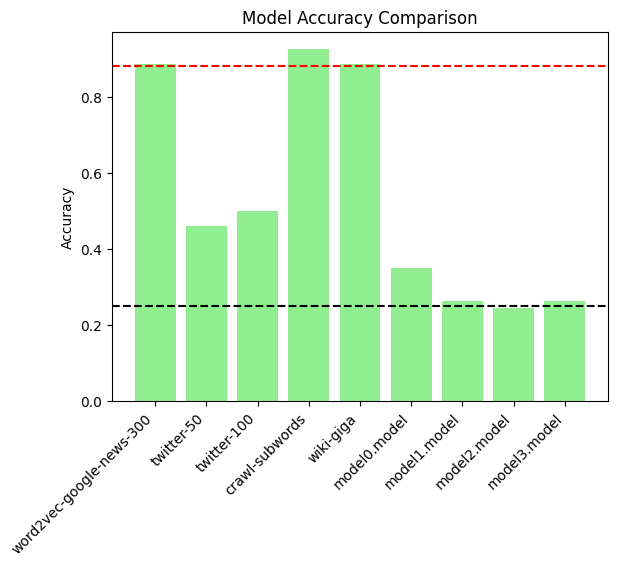

In [96]:
#analysis
df_for_graph = pd.read_csv('analysis.csv',header=None)

# Assuming you have a list of model names and their corresponding accuracies

model_names = df_for_graph[0]
model_accuracies =  df_for_graph[4]

student_predictions = 88.28

baseline = 0.25



# Sample data
names = df_for_graph[0]
accuracy = df_for_graph[4]

# Plot the bar graph
plt.xticks(rotation=45, ha='right')

plt.bar(names, accuracy, color='lightgreen')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add lines at y = 0.88 and y = 0.25
plt.axhline(y=0.88, color='red', linestyle='--', label='Threshold 1')
plt.axhline(y=0.25, color='black', linestyle='--', label='Threshold 2')


In [53]:
def part_three():

    # Load the text from the files into a list
    books = []
    book_names = ['alice_in_wonderland.txt','frankenstein.txt','great_gatsby.txt','pride_and_prejudice.txt','scarlett_letter.txt']
    for book in book_names:
        with open(f'books/{book}', 'r', encoding='utf-8') as file:
            try:
                text = file.read()
                sentences = sent_tokenize(text)
                words = [word_tokenize(sentence) for sentence in sentences]
                books.extend(words)
            except:
                continue
    window_sizes = [50, 100] #the number of words before and after
    embedding_sizes = [100, 300] # the number of hidden layer
    i = 0
    for window_size in window_sizes:
        for embedding_size in embedding_sizes:
            model = Word2Vec(books, vector_size=embedding_size, window=window_size, min_count=1, workers=4)
            
            model.save(f'model{i}.model')
            i = i+1
    return books

In [65]:

books = part_three()

def analysis_part_three(books):
    loaded_model = Word2Vec.load('model0.model')
    loaded_model.train(books,total_examples=len(books),epochs=2)

    write_model_to_csv('model0.model',loaded_model.wv)
    string_output = get_analysis('model0.model',loaded_model.wv)
    write_analysis(f'{string_output}')

    loaded_model = Word2Vec.load('model1.model')
    loaded_model.train(books,total_examples=len(books),epochs=2)

    write_model_to_csv('model1.model',loaded_model.wv)
    string_output = get_analysis('model1.model',loaded_model.wv)
    write_analysis(f'{string_output}')

    loaded_model = Word2Vec.load('model2.model')
    loaded_model.train(books,total_examples=len(books),epochs=2)

    write_model_to_csv('model2.model',loaded_model.wv)
    string_output = get_analysis('model2.model',loaded_model.wv)
    write_analysis(f'{string_output}')

    loaded_model = Word2Vec.load('model3.model')
    loaded_model.train(books,total_examples=len(books),epochs=2)

    write_model_to_csv('model3.model',loaded_model.wv)
    string_output = get_analysis('model3.model',loaded_model.wv)
    write_analysis(f'{string_output}')

    
analysis_part_three(books)

KeyError: appropriately
KeyError: uniquely
KeyError: stipulations
KeyError: interrelations
KeyError: jurisdictions
KeyError: interpretations
KeyError: dangerously
KeyError: densely
KeyError: randomly
KeyError: linearly
KeyError: battered
KeyError: outset
KeyError: tiny
KeyError: imperfect
KeyError: lustrous
KeyError: crude
KeyError: typically
KeyError: financing
KeyError: succinctly
KeyError: information
KeyError: ceremonies
KeyError: greetings
KeyError: privileges
KeyError: accelerate
KeyError: logical
KeyError: demonstrated
KeyError: training
KeyError: salaries
KeyError: subjects
KeyError: benefits
KeyError: expensive
KeyError: beautiful
KeyError: popular
KeyError: complicated
KeyError: depicted
KeyError: location
KeyError: chemically
KeyError: boring
KeyError: farming
KeyError: war
KeyError: argument
KeyError: election
KeyError: competition
KeyError: limitless
KeyError: structural
KeyError: entertaining
KeyError: incidental
KeyError: imposed
KeyError: believed
KeyError: requested
Ke

In [55]:
#loaded_model = Word2Vec.load('word2vec_model_w10_e50.model')
#loaded_model.train(books,total_examples=len(books),epochs=2)